In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mugan1","key":"1e7737f2708c99e5cec5976bb162f6fb"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/9.10M [00:00<?, ?B/s]
100% 9.10M/9.10M [00:00<00:00, 84.2MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.39MB/s]
 97% 267M/276M [00:02<00:00, 159MB/s]
100% 276M/276M [00:02<00:00, 130MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 88.1MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 127MB/s]
 82% 65.0M/79.1M [00:00<00:00, 81.9MB/s]
100% 79.1M/79.1M [00:00<00:00, 102MB/s] 
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 100MB/s]


In [4]:
import zipfile
import os
import numpy as np
import tensorflow as tf
import random
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import glob
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label
import torch.nn as nn
import torch.nn.functional as F
import functools
import argparse
import math
import itertools
import time
import datetime
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-processing

In [19]:
np.random.seed = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
PATH = '/content/drive/MyDrive/torch_project/medi/GAN/'
DATASET_NAME = "dataset_hist"
N_EPOCHS = 1000
EPOCH = 400
sample_interval = 50
checkpoint_interval = 100

In [5]:
with zipfile.ZipFile('./stage1_train.zip') as z:
    z.extractall('stage1_train')

with zipfile.ZipFile('./stage1_test.zip') as z:
    z.extractall('stage1_test')
    
with zipfile.ZipFile('./stage1_test.zip') as z:
    z.extractall('stage2_test_final')    

In [6]:
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'
FINAL_PATH = './stage2_test_final/'

In [7]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
final_ids = next(os.walk(FINAL_PATH))[1]

In [11]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

Resizing training images and masks


100%|██████████| 670/670 [08:54<00:00,  1.25it/s]


In [12]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=1)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((536, 512, 512, 3),
 (134, 512, 512, 3),
 (536, 512, 512, 1),
 (134, 512, 512, 1))

In [14]:
class Nuc_Seg(Dataset):
    def __init__(self, images_np, masks_np, train=True):
        self.images_np = images_np
        self.masks_np = masks_np
        self.train = train
    
    def transform(self, image_np, mask_np):
        if self.train :
          ToPILImage = transforms.ToPILImage()
          image = ToPILImage(image_np)
          mask = ToPILImage(mask_np.astype(np.int32))
          
          image = TF.pad(image, padding = 20, padding_mode = 'reflect')
          mask = TF.pad(mask, padding = 20, padding_mode = 'reflect')
          
          angle = random.uniform(-10, 10)
          width, height = image.size
          max_dx = 0.1 * width
          max_dy = 0.1 * height
          translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
          scale = random.uniform(0.8, 1.2)
          shear = random.uniform(-0.5, 0.5)
          
          image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
          mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
          image = TF.center_crop(image, (512, 512))
          mask = TF.center_crop(mask, (512, 512))

          image = TF.to_tensor(image)
          mask = TF.to_tensor(mask)
        else : 
          ToPILImage = transforms.ToPILImage()
          image = ToPILImage(image_np)
          mask = ToPILImage(mask_np.astype(np.int32))
          
          image = TF.to_tensor(image)
          mask = TF.to_tensor(mask)

        return image, mask
        
    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return {'A': image, 'B': mask}  

In [15]:
train_dataset = Nuc_Seg(x_train, y_train, train=True)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
valid_dataset = Nuc_Seg(x_val, y_val, train=False)
valid_loader = DataLoader(valid_dataset, batch_size = 16, shuffle = True)

# GAN Model

In [16]:

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

##############################
#           U-NET
##############################

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
                    nn.InstanceNorm2d(out_size),
                    nn.ReLU(inplace=True)]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.0)
        self.down5 = UNetDown(512, 512, dropout=0.0)
        self.down6 = UNetDown(512, 512, dropout=0.0)
        self.down7 = UNetDown(512, 512, dropout=0.0)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.0)
        self.up1 = UNetUp(512, 512, dropout=0.0)
        self.up2 = UNetUp(1024, 512, dropout=0.0)
        self.up3 = UNetUp(1024, 512, dropout=0.0)
        self.up4 = UNetUp(1024, 512, dropout=0.0)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh()
        )


    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

##############################
#        Discriminator
##############################

class PixelDiscriminator(nn.Module):
    def __init__(self, input_nc=4, ndf=64, norm_layer=nn.BatchNorm2d, use_sigmoid=False, gpu_ids=[]):
        super(PixelDiscriminator, self).__init__()
        self.gpu_ids = gpu_ids
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            norm_layer(ndf * 4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            norm_layer(ndf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=2, padding=1, bias=False)]

        if use_sigmoid:
            self.net.append(nn.Sigmoid())

        self.net = nn.Sequential(*self.net)

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.net(img_input)

# Train

In [25]:
os.makedirs('images/%s' % DATASET_NAME, exist_ok=True)
os.makedirs('saved_model/%s' % DATASET_NAME, exist_ok=True)

cuda = True if torch.cuda.is_available() else False

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Calculate output of image discriminator (PatchGAN)
patch = (1, IMG_HEIGHT//2**5, IMG_WIDTH//2**5)

# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = PixelDiscriminator()

if cuda:
    generator = torch.nn.DataParallel(generator).cuda()
    discriminator = torch.nn.DataParallel(discriminator).cuda()

    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

if EPOCH != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load(os.path.join(PATH,'saved_model/%s/generator_%d.pth' % (DATASET_NAME, EPOCH))))
    discriminator.load_state_dict(torch.load(os.path.join(PATH,'saved_model/%s/discriminator_%d.pth' % (DATASET_NAME, EPOCH))))
else:
    # Initialize weights

    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def sample_images(batches_done, path):
    """Saves a generated sample from the validation set"""
    imgs = next(iter(valid_loader))
    real_A = Variable(imgs['A'].type(Tensor))
    real_B = Variable(imgs['B'].type(Tensor))
    fake_B = generator(real_A)
    os.makedirs(os.path.join(path,'images/%s/img/' % DATASET_NAME), exist_ok=True)
    os.makedirs(os.path.join(path,'images/%s/gt/' % DATASET_NAME), exist_ok=True)
    os.makedirs(os.path.join(path,'images/%s/pred/' % DATASET_NAME), exist_ok=True)
    save_image(real_A, os.path.join(path,'images/%s/img/%s_image.png' % (DATASET_NAME, batches_done)), nrow=3, normalize=True, scale_each=True)
    save_image(real_B, os.path.join(path,'images/%s/gt/%s_image.png' % (DATASET_NAME, batches_done)), nrow=3, normalize=True, scale_each=True)
    save_image(fake_B, os.path.join(path,'images/%s/pred/%s_image.png' % (DATASET_NAME, batches_done)), nrow=3, normalize=True, scale_each=True)

prev_time = time.time()

for epoch in range(EPOCH, N_EPOCHS):
    for i, batch in enumerate(train_loader):

        # Model inputs
        real_A = Variable(batch['A'].type(Tensor))
        real_B = Variable(batch['B'].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_B = generator(real_A)
        pred_fake = discriminator(real_A,fake_B)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # Loss weight of L1 pixel-wise loss between translated image and real image
        lambda_pixel = 0.99

        # Total loss
        loss_G = (1-lambda_pixel)*loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_A,real_B)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(real_A, fake_B.detach())
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(train_loader) + i
        batches_left = N_EPOCHS * len(train_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s" %
                                                        (epoch, N_EPOCHS,
                                                        i, len(train_loader),
                                                        loss_D.item(), loss_G.item(),
                                                        loss_pixel.item(), loss_GAN.item(),
                                                        time_left))

        # If at sample interval save image
        if batches_done % sample_interval == 0:
            sample_images(batches_done, PATH)

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), os.path.join(PATH, 'saved_model/%s/generator_%d.pth' % (DATASET_NAME, epoch)))
        torch.save(discriminator.state_dict(), os.path.join(PATH, 'saved_model/%s/discriminator_%d.pth' % (DATASET_NAME, epoch)))

[Epoch 999/1000] [Batch 33/34] [D loss: 0.126438] [G loss: 0.023865, pixel: 0.020033, adv: 0.403217] ETA: 0:00:01.215944

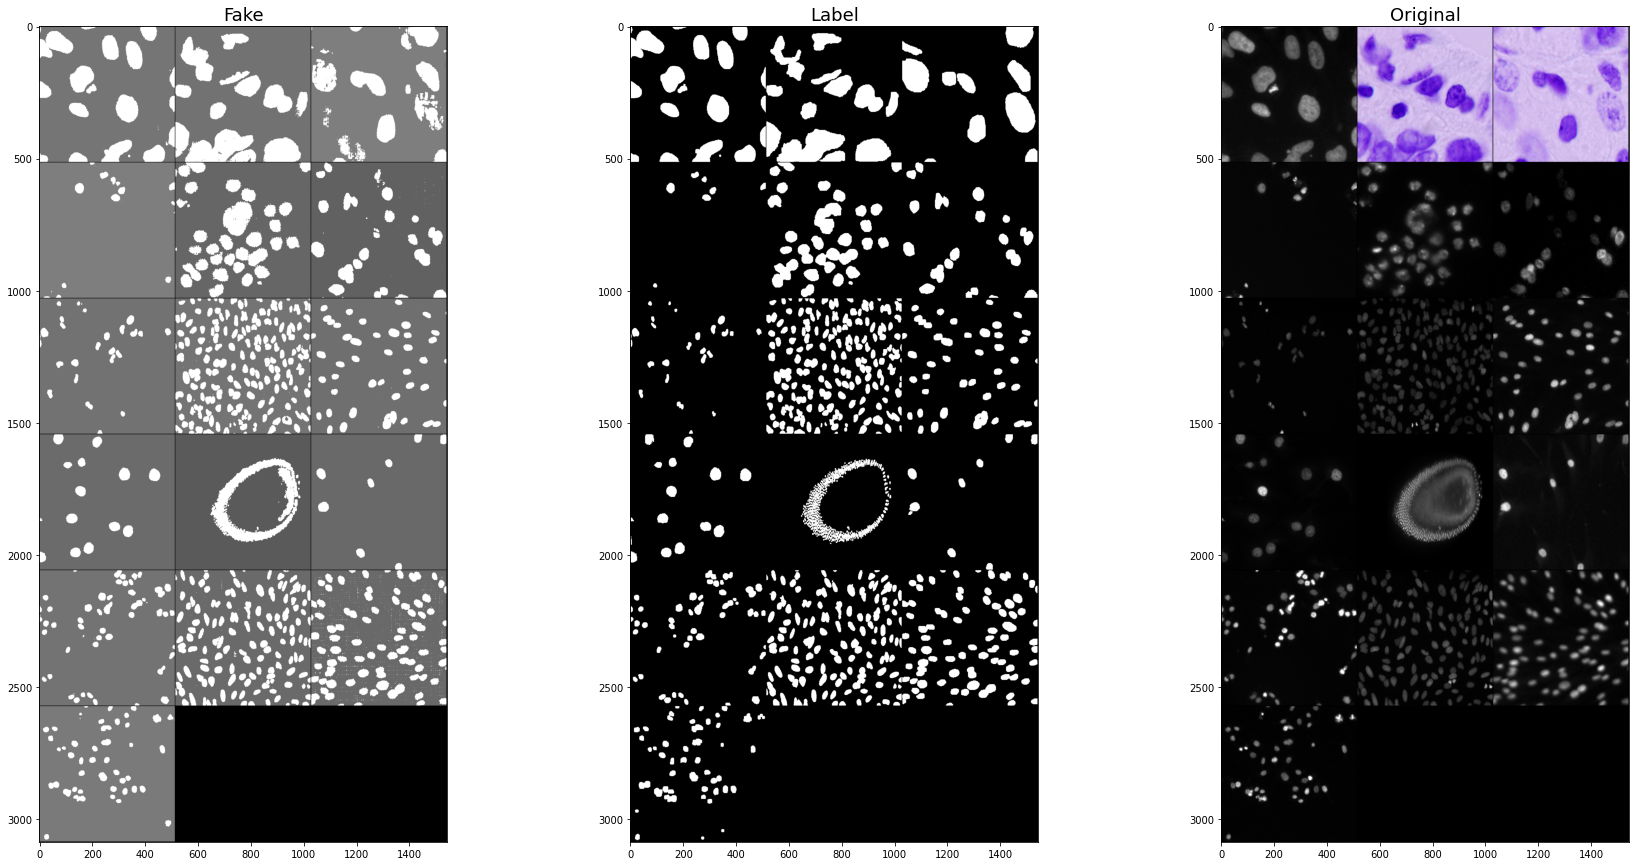

In [58]:
pred_img_dir = os.path.join(PATH,'images/%s/pred/%s_image.png' % (DATASET_NAME, 33950))
gt_img_dir = os.path.join(PATH,'images/%s/gt/%s_image.png' % (DATASET_NAME, 33950))
og_img_dir = os.path.join(PATH,'images/%s/img/%s_image.png' % (DATASET_NAME, 33950))
pred_img = plt.imread(pred_img_dir)
gt_img = plt.imread(gt_img_dir)
og_img = plt.imread(og_img_dir)

fig, ax = plt.subplots(1,3, figsize=(30,15))
ax[0].imshow(pred_img)
ax[0].set_title("Fake", fontsize=18)
ax[1].imshow(gt_img)
ax[1].set_title("Label", fontsize=18)
ax[2].imshow(og_img)
ax[2].set_title("Original", fontsize=18);

# Test

In [61]:
test_dataset = Nuc_Seg(x_val, y_val, train=False)
test_dataloader = DataLoader(valid_dataset, batch_size = 1, shuffle = True)

In [65]:
def dice_coeff(seg, gt):
    smooth = .0001
    return (np.sum(seg[gt == 1])*2.0 + smooth) / (np.sum(seg) + np.sum(gt) + smooth)

def sample_images(imgs, model, path, idx=None,save=False):
    """Saves a generated sample from the test set"""
    true_map = Variable(imgs['B'].type(Tensor))
    save_image(true_map, os.path.join(path, 'test_results/gt', str(idx)) +'.jpg', normalize=True)
    fake_B = model(Variable(imgs['A'].type(Tensor)))
    if save:
        save_image(fake_B, os.path.join(path, 'test_results/pred_map', str(idx)) +'.jpg', normalize=True)
    return fake_B

def evaluationMetric(image, thresh, path):
    print(image)
    path = os.path.join(path, 'test_results/pred_map/')
    map_GT = Image.open(image)
    map_pred = Image.open(os.path.join(path, image.split('/')[-1]))
    w, h = map_GT.size

    # Binarize the prediction and groundtruth
    true_labels = np.reshape(np.asarray(map_GT)[:,:,1], (w*h,1))
    true_labels = np.where(true_labels > thresh, 1, 0)
    pred_labels = np.reshape(np.asarray(map_pred)[:,:,1], (w*h,1))
    pred_labels = np.where(pred_labels > thresh, 1, 0)

    ##Dice Coeff
    dice = dice_coeff(pred_labels,true_labels)

    return dice

# Initialize generator and discriminator
cuda = True if torch.cuda.is_available() else False

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

generator = GeneratorUNet()

if cuda:
    generator = torch.nn.DataParallel(generator).cuda()

generator.load_state_dict(torch.load(os.path.join(PATH, 'saved_model/dataset_hist/generator_900.pth')))
generator.eval()

elapse = []
os.makedirs(os.path.join(PATH, 'test_results/gt/'), exist_ok=True)
os.makedirs(os.path.join(PATH, 'test_results/image/'), exist_ok=True)
os.makedirs(os.path.join(PATH, 'test_results/pred_map/'), exist_ok=True)
for i, image in enumerate(test_dataloader):
    print('Testing image ', i)
    start = time.process_time()
    sample_images(image, generator, PATH, idx=i, save=True)
    elapsed = (time.process_time() - start)
    elapse.append(elapsed)
    print(elapsed)
    save_image(image['A'], os.path.join(PATH,'test_results/image/', str(i) +'.jpg'), normalize=True)
print('Average testing time is ', np.mean(elapse))

#######################
BER_avg   = []
dice_avg = []
for file in glob.glob(os.path.join(PATH, 'test_results/gt/**/*.jpg'), recursive=True):
    thresh = 200  # grayscale intensity
    dice = evaluationMetric(file, thresh, PATH)
    dice_avg.append(dice)

print(sum(dice_avg) / float(len(dice_avg)))

Testing image  0
0.06449723799960339
Testing image  1
0.0636774200029322
Testing image  2
0.06665487400096026
Testing image  3
0.06087214999934076
Testing image  4
0.06334162700295565
Testing image  5
0.06693059600002016
Testing image  6
0.059320601998479106
Testing image  7
0.06271829799879924
Testing image  8
0.06509175899918773
Testing image  9
0.06483162000222364
Testing image  10
0.059379001999332104
Testing image  11
0.0668212679993303
Testing image  12
0.06176757399953203
Testing image  13
0.06752249599958304
Testing image  14
0.06379123800070374
Testing image  15
0.06104108599902247
Testing image  16
0.05993890100216959
Testing image  17
0.06853533100002096
Testing image  18
0.06676691999746254
Testing image  19
0.06220108900015475
Testing image  20
0.06437935600115452
Testing image  21
0.06285613100044429
Testing image  22
0.06392857700120658
Testing image  23
0.06336754299991298
Testing image  24
0.06205334599872003
Testing image  25
0.06684922500062385
Testing image  26
0.06

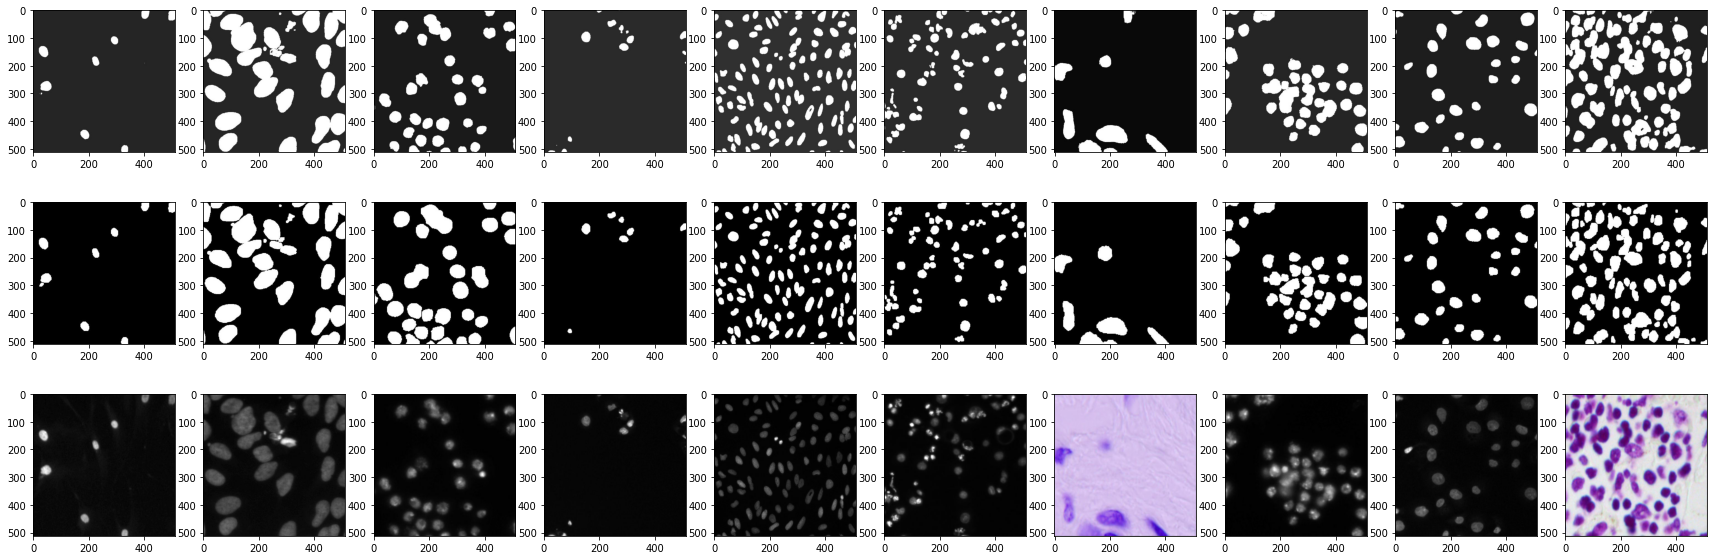

In [97]:
pred_list = glob.glob('/content/drive/MyDrive/torch_project/medi/GAN/test_results/pred_map/*.jpg')
gt_list = glob.glob('/content/drive/MyDrive/torch_project/medi/GAN/test_results/gt/*.jpg')
or_list = glob.glob('/content/drive/MyDrive/torch_project/medi/GAN/test_results/image/*.jpg')

fig=plt.figure(figsize=(30,10))
for index, number in enumerate(3*random.sample(range(0,len(pred_list)), 10)):
  if index <= 9 :
    img = plt.imread(pred_list[index])
  elif index <= 19 :
    img = plt.imread(gt_list[index-10])
  else:
    img = plt.imread(or_list[index-20])
  ax = fig.add_subplot(3, 10, index+1)
  ax.imshow(img)